In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
# from train_bbnet import get_args, load_model
from train import get_args, load_model
import datasets as raft_datasets
import utils.flow_viz as flow_viz

def set_args(args_dict={}):
    args = get_args("")
    for k,v in args_dict.items():
        args.__setattr__(k, v)
    return args

def tensor_to_arr(tensor, ex=0):
    if len(tensor.shape) == 4:
        tensor = tensor[ex]
    return tensor.detach().permute(1, 2, 0).cpu().numpy()

def viz(tensor, ex=0):
    im = tensor_to_arr(tensor, ex)
    if im.max() > 2.0:
        im = im / 255.0
    plt.imshow(im)
    
def zscore(x, eps=1e-6):
    m = x.mean((-2,-1), True)
    s = x.std((-2,-1), True)
    return (x - m) / s.clamp(min=eps)

def get_patches(im, radius=1):
    if radius == 0:
        return im
    shape = im.shape
    if len(shape) == 5:
        im = im.view(shape[0]*shape[1], *shape[2:])
    B,C,H,W = im.shape
    
    im = F.pad(im, (radius, radius, radius, radius))
    k = 2*radius+1
    im = F.unfold(im, (k, k)).view(-1,C*(k**2),H,W)
    if len(shape) == 5:
        im = im.view(shape[0], shape[1], *im.shape[1:])
    return im    
    
def vis_local_affinities(affinities, node=[250,400]):
    aff_node = affinities[:,:,node[0],node[1]]

    A = torch.zeros_like(affinities)
    A[:,:,node[0],node[1]] = aff_node
    K = (aff_node.shape[-1] - 1) // 2
#     aff_node = torch.cat([A[:,:K], torch.zeros_like(A[:,:1]), A[:,K:]], 1)    
    aff_node = torch.cat([A[:,:K], torch.zeros_like(A[:,:1]), A[:,(K+1):]], 1)        
    effects = fprop.compute_local_effects(torch.ones_like(affinities[:,:1]), aff_node)
    return effects

def viz_raft_prediction(model, dataset, ex=0, iters=[1,12,24], thingness=False, 
                        centroid=False, thresh=None, time_it=False, is_test=False, sigmoid=True):
    dataset.is_test = is_test
    dataset.get_backward_frame = False
    if ex is None:
        ex = np.random.randint(0, len(dataset))
    try:
        img1, img2, gt, _ = dataset[ex]
    except:
        img1, img2 = dataset[ex][:2]
        gt = None
    dataset.get_backward_frame = True
    preds = []
    if not isinstance(iters, list):
        iters = [iters]
    for it in iters:
        s = time.time()
        _, pred = model(img1[None].cuda(), img2[None].cuda(), iters=it, test_mode=True)
        e = time.time()
        if time_it:
            print("%0.3f seconds for %d iters" % (e - s, it)) 
        if thingness:
            pred = (nn.Sigmoid() if sigmoid else nn.Identity())(pred)[0,0].detach().cpu().numpy()
            if thresh is not None:
                pred = (pred > thresh)
        elif centroid:
            pass
        else:
            if thresh is None:
                pred = flow_viz.flow_to_image(tensor_to_arr(pred))
            else:
                pred = pred.square().sum(-3, True).sqrt()[0,0].detach().cpu().numpy()
                pred = (pred > thresh)
        preds.append(pred)
    if gt is not None:
        _flow_gt = flow_viz.flow_to_image(tensor_to_arr(gt))

    fig, axes = plt.subplots(
        1,1 + len(iters) + int(gt is not None), figsize=(4 + 4*int(gt is not None) + 4*len(iters),4))
    axes[0].imshow(img1.permute(1, 2, 0).numpy() / 255.)
    for i in range(len(iters)):
        axes[1+i].imshow(preds[i])
    if gt is not None:
        axes[-1].imshow(_flow_gt)
    
    titles = ['img1'] + ['pred @ %d iters' % it for it in iters] + (['gt'] if gt is not None else [])
    
    for i, ax in enumerate(axes):
        ax.set_title(titles[i], fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()  
    

def viz_boundary_preds(b_preds, thresh=0.1, max_speed=0.1, do_plot=True):
    if b_preds.shape[1] == 9:
        c1_preds, b_preds, c2_preds = b_preds.split([4,1,4], dim=-3)
        c_preds = torch.cat([c1_preds, c2_preds], -3).softmax(-3)
        c_preds_rgb = fprop.circular_target_to_spatial_moment(c_preds)
    elif b_preds.shape[1] == 3:
        b_preds, c_preds = b_preds.split([1,2], dim=-3)
        c_preds_rgb = c_preds
    b_preds = b_preds.sigmoid()
    if do_plot:
        vis_utils.imshow(data_utils.FlowToRgb(max_speed=max_speed)(c_preds_rgb) * (b_preds > thresh).float())    
    return (b_preds, c_preds)


def get_boundary_preds(model, dataset, ex, static_input=True, backward=False, iters=12):
    img1, img2 = [x[None].cuda() for x in dataset[ex][:2]]
    if backward:
        ups_mask, b_preds = model(img2, img2 if static_input else img1, test_mode=True, iters=iters)
    else:
        ups_mask, b_preds = model(img1, img1 if static_input else img2, test_mode=True, iters=iters)
    return (b_preds, ups_mask)

def get_boundary_movie(model, dataset, ex, iters=12, thresh=0.1):
    img1, img2, img0 = [x[None].cuda() for x in dataset[ex][:3]]
    b1 = model(img1, img1, test_mode=True, iters=12)[-1]
    b2 = model(img2, img2, test_mode=True, iters=12)[-1]
    b0 = model(img0, img0, test_mode=True, iters=12)[-1]
    b_movie = []
    for b in [b0, b1, b2]:
        b_preds, c_preds = viz_boundary_preds(b, do_plot=False)
        b_movie.append((b_preds > thresh).float() * c_preds)
    return torch.stack(b_movie, 1)


/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:696: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  collections.MutableMapping.register(ParseResults)
/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:2273: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif isinstance( exprs, collections.Sequence ):
/home/dbear/tenv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:568: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [4]:
import dorsalventral.models.targets as targets
import dorsalventral.vis_utils as vis_utils
import dorsalventral.data.utils as data_utils
import dorsalventral.models.fire_propagation as fprop
import dorsalventral.models.layer_utils as layer_utils
import dorsalventral.models.segmentation.competition as competition
import kornia

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
tdw_dataset = raft_datasets.TdwFlowDataset(
#     root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
    root='/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/',
#     dataset_names=['model_split_4'],    
    dataset_names=['model_split_%d' % split for split in range(5)],
    split='training',
    filepattern="*",
#     test_filepattern="0*[0-4]",
    test_filepattern="*9",
    min_start_frame=5,
    max_start_frame=5,
    scale_to_pixels=True,
    get_gt_flow=True,
    get_backward_frame=True
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)

6250
False


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 1. Create a training target for occlusion edges (boundaries)

In [6]:
# motion_paths = !ls ../checkpoints/[0-9]*motion*dtarg*pr1*fullplayall*
motion_paths = !ls ../checkpoints/[0-9]*boundaryStaticReg*nthr*pr1*fullplay*
# motion_paths = !ls ../checkpoints/[0-9]*boundaryMotion*pr1*

motion_paths = sorted(motion_paths, key=lambda s: int(s.split('/')[-1].split('_')[0]))
# !ls ../checkpoints/*motion*imtarg*thr0*
for i,p in enumerate(motion_paths):
    print(i, p)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 ../checkpoints/5000_boundaryStaticReg-rnd0-tdw-bs4-small-dtarg-nthr0-cthr05-pr1-tds2-fullplayall.pth
1 ../checkpoints/5000_boundaryStaticReg-rnd0-tdw-bs4-small-dtarg-nthr0-cthr075-pr1-tds2-fullplayall.pth
2 ../checkpoints/10000_boundaryStaticReg-rnd0-tdw-bs4-small-dtarg-nthr0-cthr05-pr1-tds2-fullplayall.pth
3 ../checkpoints/10000_boundaryStaticReg-rnd0-tdw-bs4-small-dtarg-nthr0-cthr075-pr1-tds2-fullplayall.pth
4 ../checkpoints/15000_boundaryStaticReg-rnd0-tdw-bs4-small-dtarg-nthr0-cthr05-pr1-tds2-fullplayall.pth
5 ../checkpoints/15000_boundaryStaticReg-rnd0-tdw-bs4-small-dtarg-nthr0-cthr075-pr1-tds2-fullplayall.pth
6 ../checkpoints/20000_boundaryStaticReg-rnd0-tdw-bs4-small-dtarg-nthr0-cthr05-pr1-tds2-fullplayall.pth
7 ../checkpoints/20000_boundaryStaticReg-rnd0-tdw-bs4-small-dtarg-nthr0-cthr075-pr1-tds2-fullplayall.pth
8 ../checkpoints/25000_boundaryStaticReg-rnd0-tdw-bs4-small-dtarg-nthr0-cthr05-pr1-tds2-fullplayall.pth
9 ../checkpoints/25000_boundaryStaticReg-rnd0-tdw-bs4-small-dt

In [7]:
# IM = targets.IsMovingTarget(
#     warp_radius=3,
#     thresh=None,
#     get_errors=False,
#     normalize_features=False,
#     warp_dilation=1,
#     patch_radius=0
# ).cuda()

# motion_path = '../checkpoints/50000_motion-rnd0-tdw-bs4-large-dtarg-cthr05-pr1-tds2-fullplayall.pth'

b_idx = 12
boundary_path = motion_paths[b_idx]

b_net = load_model(
    boundary_path,
    small=True,
    static_input=True,
    orientation_type='regression',
    cuda=True, 
    train=False)
b_net.module.freeze_bn()
b_net.eval()
print(layer_utils.num_parameters(b_net))

# mclass_net = load_model(
#                        motion_path,
#                        small=False, 
#                        cuda=True, 
#                        train=False)
# mclass_net.module.freeze_bn()
# mclass_net.eval()
# print(layer_utils.num_parameters(mclass_net))



/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully> BoundaryClassifier
1600277


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


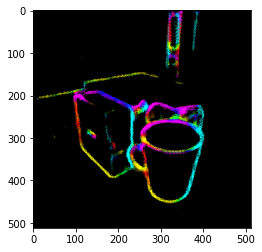

In [8]:
ex = 11
tdw_dataset.is_test = True
_ = viz_boundary_preds(get_boundary_preds(b_net, tdw_dataset, ex, iters=12)[0])

In [9]:
motion_paths = !ls ../checkpoints/[0-9]*motion*dtarg*nthr*pr1*fullplayall*
# motion_paths = !ls ../checkpoints/[0-9]*boundaryStaticReg*nthr*pr1*fullplay*
# motion_paths = !ls ../checkpoints/[0-9]*boundaryMotion*pr1*

motion_paths = sorted(motion_paths, key=lambda s: int(s.split('/')[-1].split('_')[0]))
# !ls ../checkpoints/*motion*imtarg*thr0*
for i,p in enumerate(motion_paths):
    print(i, p)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 ../checkpoints/5000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall.pth
1 ../checkpoints/5000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr05-pr1-tds2-fullplayall.pth
2 ../checkpoints/10000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall.pth
3 ../checkpoints/10000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr05-pr1-tds2-fullplayall.pth
4 ../checkpoints/15000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall.pth
5 ../checkpoints/15000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr05-pr1-tds2-fullplayall.pth
6 ../checkpoints/20000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall.pth
7 ../checkpoints/20000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr05-pr1-tds2-fullplayall.pth
8 ../checkpoints/25000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall.pth
9 ../checkpoints/25000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr05-pr1-tds2-fullplayall.pth


In [10]:
m_idx = 8
motion_path = motion_paths[m_idx]

mclass_net = load_model(
                       motion_path,
                       small=False, 
                       cuda=True, 
                       train=False)
mclass_net.module.freeze_bn()
mclass_net.eval()
print(layer_utils.num_parameters(mclass_net))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully> MotionClassifier
5555009


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


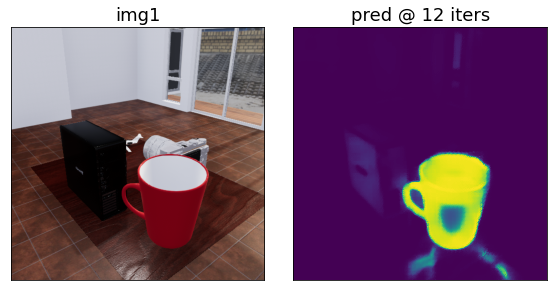

In [11]:
import time
ex = 11
thresh = None
viz_raft_prediction(mclass_net, tdw_dataset, ex=ex, iters=[12], thingness=True, thresh=thresh, is_test=True)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


video torch.Size([3, 3, 512, 512])
b video tensor(0.8674, device='cuda:0', grad_fn=<AmaxBackward>) tensor(-0.7226, device='cuda:0', grad_fn=<AminBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


energy? False


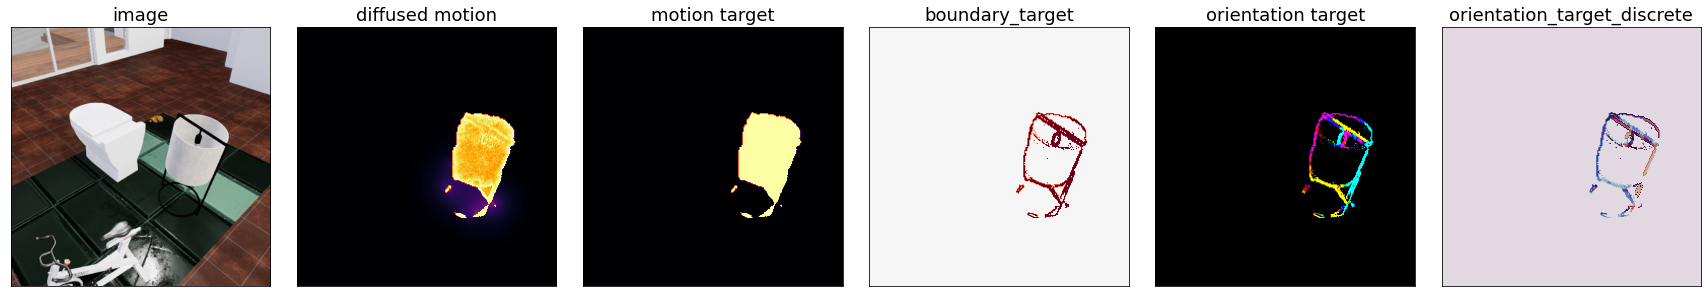

In [16]:
DTarget = fprop.DiffusionTarget(
    num_points=(2**14),
    confidence_thresh=0.5, 
    num_samples=8,
    patch_radius=1,
    noise_thresh=0.9,
    num_iters=1000,
    downsample_factor=1
).cuda()
DTarget.eval()

ex = 5041
use_prior = True
DTarget.energy_prior_gate = (not use_prior)
prior_thresh = 0.75
b_thresh = 0.1
stride = 2
tdw_dataset.is_test = False
tdw_dataset.get_backward_frame = True

data = tdw_dataset[ex]
video = torch.stack([x.cuda() for x in [data[0], data[1], data[2]]], 0) / 255.
_, mprior = mclass_net(video[-2:-1] * 255., video[-1:] * 255., test_mode=True, iters=24)
mprior = mprior.sigmoid()
b_video = get_boundary_movie(b_net, tdw_dataset, ex=ex, thresh=b_thresh)
# video = torch.cat([video, b_video[0]], -3)
# video = b_video[0]
print("video", video.shape)
print("b video", b_video.amax(), b_video.amin())

_video = transforms.Resize([512 // stride, 512 // stride])(video)
if list(mprior.shape[-2:]) != list(_video.shape[-2:]):
    mprior = transforms.Resize(_video.shape[-2:])(mprior)

# ex = 5021
# data = tdw_dataset[ex]
# _video = torch.stack([x.cuda() for x in [data[0], data[1], data[2]]], 0) / 255.

# target = DTarget(torch.stack([video, _video], 0))
train_targets = DTarget(_video[None], energy=(mprior if use_prior else None))
# train_targets = DTarget(_video[None], energy=None)
# target, b_target, c_target, c_target_discrete = targets
target, b_target = train_targets
b_target, c_target, c_target_discrete = b_target.split([1,2,8], dim=1)

# target_prior = DTarget(_video[None], 
#                        energy=(mprior.sigmoid() > prior_thresh).float(),
#                        boundaries=kornia.filters.sobel(mprior.sigmoid())
#                       )

# target = IM(video[None]
titles = ['image', 'diffused motion', 
          'motion target', 'boundary_target', 
          'orientation target', 'orientation_target_discrete']
fig, axes = plt.subplots(1,6,figsize=(24,4))
vis_utils.imshow(video[1:2,0:3], axes[0])
vis_utils.imshow(target, axes[2], cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(DTarget.h_final, axes[1], cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(b_target, axes[3], cmap='RdBu_r', vmin=-1, vmax=1)
vis_utils.imshow(data_utils.FlowToRgb(max_speed=0.1)(c_target), axes[4])
clock = torch.tensor([0,1,2,4,7,6,5,3]).long()
vis_utils.imshow(c_target_discrete[:,clock].argmax(1, True), axes[5], cmap='twilight', vmin=0, vmax=8)
# vis_utils.imshow(mprior.sigmoid(), axes[2], cmap='inferno', vmin=0, vmax=1)
# vis_utils.imshow(mprior.sigmoid() > prior_thresh, axes[3], cmap='inferno', vmin=0, vmax=1)
# vis_utils.imshow(target_prior, axes[4], cmap='inferno', vmin=0, vmax=1)

for i, ax in enumerate(axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], fontsize=18)
plt.tight_layout()
plt.show()

In [10]:
itarg = IM(_video[None])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


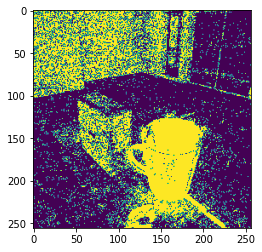

In [15]:
vis_utils.imshow(itarg[0] > 0.0)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


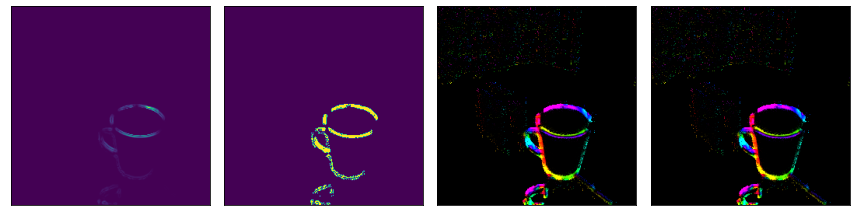

In [72]:
fig, axes = plt.subplots(1,4,figsize=(12,4))

vis_utils.imshow(DTarget.boundaries, axes[0])
vis_utils.imshow(DTarget.boundaries_sampled > 0.9, axes[1])
orgb = data_utils.FlowToRgb(0.25)(DTarget.orientations_rgb)
vis_utils.imshow(orgb, axes[2])
orgb_orig = data_utils.FlowToRgb(0.25)(ors_rgb_original)
vis_utils.imshow(orgb_orig, axes[3])
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

In [61]:
_video.shape

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([3, 3, 256, 256])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


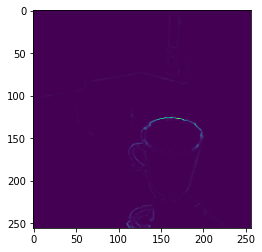

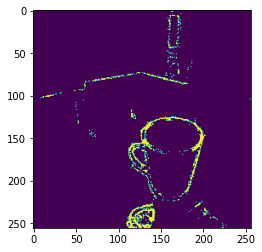

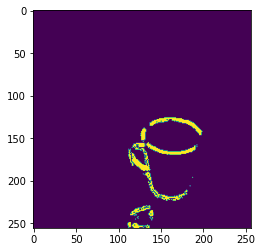

In [84]:

bounds_post = DTarget.sample_mean(kornia.filters.sobel(DTarget.h_final)) *\
                kornia.filters.sobel(_video[-2,None]).abs().sum(1, True) *\
                DTarget.sample_mean(DTarget.h_final)
bounds_sampled = DTarget.edge_sampler(bounds_post[:,None],
                                      num_points=2**14,
                                      eps=0)[0]
bounds_sampled = DTarget.sample_mean(bounds_sampled)
vis_utils.imshow(bounds_post)
vis_utils.imshow(bounds_sampled > 0.75)
vis_utils.imshow(DTarget.boundaries_sampled > 0.75)


# vis_utils.imshow(kornia.filters.sobel(_video[-2,None]).abs().sum(1, True))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


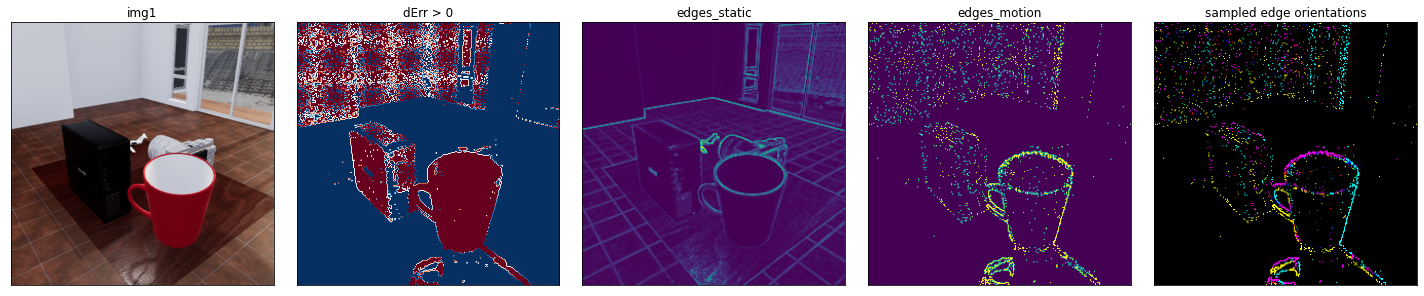

In [35]:
ex = 11
tdw_dataset.is_test = True
tdw_dataset.get_backward_frame = True
thresh = None
zthresh = 1.0
patch_radius = 1
stride = 2
num_samples = 8
P = 2**14
IM.thresh = thresh
noise = 0.0
data = tdw_dataset[ex]
video = torch.stack([x.cuda() for x in [data[0], data[1], data[2]]], 0) / 255.
# _, mprior = mclass_net(video[1,None]*255., video[2,None]*255., test_mode=True, iters=24)

# if stride > 1:
#     video = video[...,::stride,::stride]

target = IM(get_patches(video[None], radius=patch_radius))
if stride > 1:
    target = F.avg_pool2d(target[:,0], stride, stride=stride)[:,None]

ztarget = (zscore(F.relu(target[:,0])) > zthresh).float()
# derr = (zscore(ztarget[:,0]) > 0).int() - (zscore(target[:,0]) < .0).int()
derr = (target > noise).int() - (target < noise).int()
derr = derr[:,0].float() * 0.5 + 0.5

# sobel = kornia.filters.SpatialGradient(mode='sobel')(torch.cat([video[-2,None], derr], 1))
sobel = kornia.filters.SpatialGradient(mode='sobel')(video[-2,None])
sobel_mag = sobel.sum(1).abs().sum(1, True)

if stride > 1:
    sobel_mag = F.max_pool2d(sobel_mag, stride, stride=stride)

sobel_motion = kornia.filters.sobel(derr)

canny_mag, canny_bin = kornia.filters.canny(video[-2,None])

fig, axes = plt.subplots(1,5,figsize=(20,4))
titles = ['img1', 'dErr > 0', 'edges_static', 'edges_motion', 'sampled edge orientations']

# img = video[-2,None]
# red = torch.cat([ztarget, torch.zeros_like(ztarget), torch.zeros_like(ztarget)], -3)
# img = img * (1 - ztarget) + red * ztarget

# vis_utils.imshow(img, axes[0])
vis_utils.imshow(video[-2,None], axes[0])
# vis_utils.imshow(target[:,0], axes[1], cmap='inferno')
# vis_utils.imshow(target[:,0] > 0.0, axes[1], cmap='RdBu_r', vmin=0, vmax=1)
vis_utils.imshow(derr, axes[1], cmap='RdBu_r', vmin=0, vmax=1)

# vis_utils.imshow(target[:,0] > 0.0, axes[2], cmap='inferno')
vis_utils.imshow(sobel_mag, axes[2])
# vis_utils.imshow(sobel_mag * data_utils.FlowToRgb(max_speed=0.01)(sobel.mean(1)), axes[2])
vis_utils.imshow(sobel_motion, axes[3])

edges = torch.minimum(sobel_motion, sobel_mag) * F.relu(zscore(target[:,0]))
# edges = edges * F.avg_pool2d(mprior, stride, stride=stride).sigmoid()
MS = fprop.MotionEnergySampler(num_samples=num_samples, thresh=None, binarize=True, to_nodes=False)
edges_sampled = MS(edges[:,None], num_points=P, eps=0)[0].view(num_samples, 1, 512//stride, 512//stride)

# vis_utils.imshow(torch.minimum(sobel_motion, sobel_mag) * F.relu(zscore(target[:,0])), axes[4])
vis_utils.imshow(edges_sampled, axes[3])


# vis_utils.imshow(target[:,0] > 0., axes[3], cmap='inferno')
# vis_utils.imshow(sobel_mag * target[:,0], axes[3], cmap='inferno')

ors = fprop.estimate_boundary_orientations(edges_sampled,
                                           target[:,0],
#                                            (target[:,0] > noise).float() * target[:,0],
#                                            (target[:,0] > noise).float(),
#                                            (target[:,0] > 0.0).float()*F.avg_pool2d(mprior, stride, stride=stride).sigmoid(),
                                           radius=5,
                                           to_circle=False)

ors = ors * edges_sampled
ors_rgb = data_utils.FlowToRgb(max_speed=0.1)(ors)
vis_utils.imshow(ors_rgb, axes[4])


for i in range(len(axes)):
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(titles[i])
# vis_utils.imshow(zscore(F.relu(target[0])), axes[1], cmap='magma', vmin=0, vmax=thresh)
# thresh = 1.0
# vis_utils.imshow(target[0], axes[1], cmap='magma', vmin=0, vmax=0.25)
# mask = (zscore(F.relu(target[0])) > thresh).float()
# vis_utils.imshow(zscore(F.relu(target[0])) * mask, axes[2], cmap='magma', vmin=0, vmax=thresh)
# vis_utils.imshow(zscore(F.relu(target[0])) * (1-mask), axes[3], cmap='magma', vmin=0, vmax=thresh)
# # vis_utils.imshow(F.relu(target[0]) > 0.0025, axes[3])

plt.tight_layout()
plt.show()

In [12]:
S, P = 1, 2048
radius = 5
beta = 10.0
# B,_,H,W = mprior.shape
# _H,_W = [H // stride, W // stride]

b0 = edges_sampled
m0 = b0.clone()
# m0 = b0.clone() + (1 - b0.clone()) * F.avg_pool2d(mprior, stride, stride=stride).sigmoid()
# m0 = b0.clone() + (1 - b0.clone()) * (ztarget > 0.5).float()
c0 = fprop.estimate_boundary_orientations(b0, 
                                          (target[:,0] > 0.).float(), 
                                          radius=radius,
                                          to_circle=True,
                                          beta=beta)
c0 = c0 * b0
h0 = b0 + m0 * (1 - b0)

b_flux = fprop.get_oriented_flux(b0, c0, b0)
b_flux = b_flux * (1 - b0)

b_flux_mask = (fprop.compute_local_effects(
    b0, c0) > 0.5).float()

print(b0.shape, m0.shape, c0.shape)

torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256]) torch.Size([8, 9, 256, 256])


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.21101975440979004


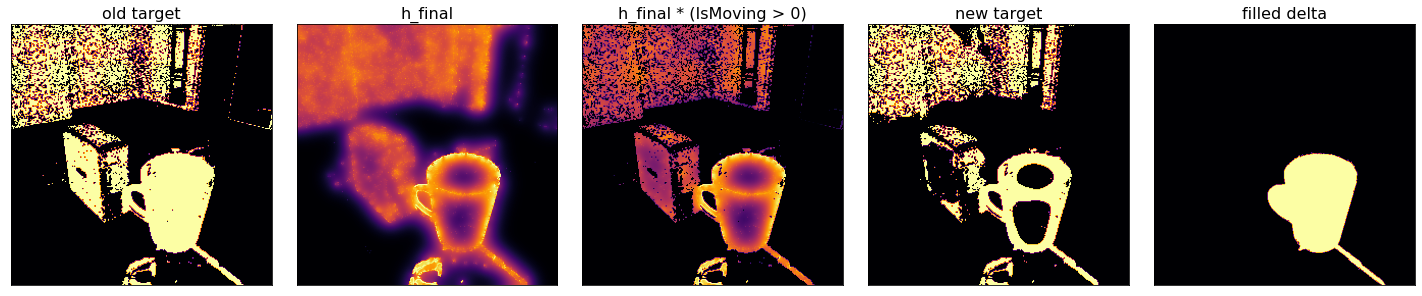

In [14]:
from time import time
slope = None

t0 = time()
eta = 1.0
h = h0.clone()

n_iters = 200
update_edges = 1000000
P_new = 2 ** 10
target_thresh = 0.5

for it in range(n_iters):
    h = h * (1-b_flux_mask) + eta * b_flux * b_flux_mask
    h_avg = fprop.local_average(h, excluded=b0)
    h = h_avg * (1-h0) + h0
    
#     h = (h > 0.5).float()

    if ((it + 1) % update_edges) == 0:
        sobel_motion = kornia.filters.sobel(h)
        edges = torch.minimum(sobel_motion, sobel_mag) * h
        b = MS(edges[:,None], num_points=P_new, eps=0)[0][:,0]
        c = fprop.estimate_boundary_orientations(b,
                                                 h,
                                                 radius=5,
                                                 to_circle=True)        
        c = c * b
        b_flux = fprop.get_oriented_flux(b, c, b)
        b_flux = b_flux * (1 - b)
        b_flux_mask = (fprop.compute_local_effects(
                b, c) > 0.5).float()        

    
t1 = time()
print(t1-t0)

h_conf = h.mean(0, True)
FDI = data_utils.FillDeltaImagesRaft(thresh=0.01)
filled_fwd = FDI(video[1][None] * 255., video[2][None] * 255.)[-1]
filled_bck = FDI(video[1][None] * 255., video[0][None] * 255.)[-1]
filled = filled_fwd * filled_bck

fig, axes = plt.subplots(1,5,figsize=(20,4))
titles = ['old target', 'h_final', 'h_final * (IsMoving > 0)', 'new target', 'filled delta']
plots = [
    (target[:,0] > noise),
#     F.relu(zscore(target[:,0])) > 0.2,
    h_conf,
    h_conf * (target[:,0] > 0.).float(),
    (h_conf * (target[:,0] > 0.).float()) > target_thresh,
    filled
]

for i,ax in enumerate(axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], fontsize=16)
    vis_utils.imshow(plots[i], ax, cmap='inferno', vmin=0, vmax=1)
plt.tight_layout()
plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


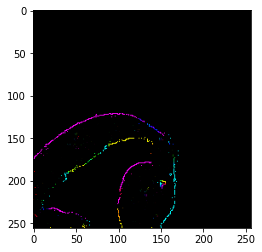

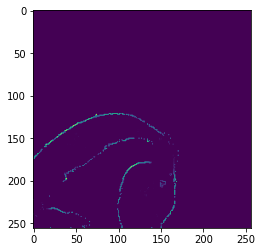

In [46]:
new_target = (h_conf * (target[:,0] > 0.).float()) > target_thresh
new_target = new_target.float()
sobel_motion = kornia.filters.sobel(new_target)
edges = torch.minimum(sobel_motion, sobel_mag) * new_target
edges_sampled = MS(edges[:,None], num_points=P, eps=0)[0][:,0]
ors = fprop.estimate_boundary_orientations(edges_sampled,
                                           new_target,
                                           radius=5,
                                           to_circle=False,
                                           beta=10.0
                                          )
ors = ors * edges_sampled
ors_rgb = data_utils.FlowToRgb(max_speed=0.1)(ors)
vis_utils.imshow(ors_rgb)
# vis_utils.imshow(sobel_motion * new_target)
vis_utils.imshow(fprop.get_mask_boundaries(new_target)[0] * edges_sampled * ors_rgb.mean(1, True))

## Eval models

In [69]:
from tqdm import tqdm
DEFAULT_CMAP = plt.cm.twilight
DEFAULT_ERRMAP_COLORS = {k:float(v)/DEFAULT_CMAP.N for k,v in {'tp': 250, 'tn': 0, 'fp': 420, 'fn': 80}.items()}

def plot_errormap(model, dataset, ex=None, iters=24, thresh=4, 
                  cmap=DEFAULT_CMAP,
                  colors=DEFAULT_ERRMAP_COLORS,
                  do_plot=True,
                  return_errormap=True,
                  return_images=False,
                  thingness=False
                 ):
    if ex is None:
        ex = np.random.randint(len(dataset))
        
    blob = dataset[ex]
    try:
        img1, img2, flow = blob[:3]
    except:
        img1, img2 = blob[:2]
        flow = torch.zeros_like(img1[:2])
    _, pred = model(img1[None].cuda(), img2[None].cuda(), iters=iters, test_mode=True)
    
    if thingness:
        _seg = lambda x, t: (torch.sigmoid(x) > t).cpu().numpy()[0,0]
    else:
        _seg = lambda x, t: (x.square().sum(-3).sqrt() > t).cpu().numpy()[0]
    pred_seg = _seg(pred, thresh)
    gt_seg = (flow.square().sum(-3).sqrt() > 0.5).cpu().numpy()
#     gt_seg = _seg(flow[None], 0.5)
    
    tp = pred_seg & gt_seg
    tn = ~pred_seg & ~gt_seg
    fp = pred_seg & ~gt_seg
    fn = ~pred_seg & gt_seg
    n = (pred_seg | gt_seg).sum() + 0.
    
    metrics = {
        'iou': tp.sum() / n,
        'precision': (tp.sum() + 0.) / (tp.sum() + fp.sum()),
        'recall': (tp.sum() + 0.) / (tp.sum() + fn.sum())
    }

    errmap = np.zeros(list(gt_seg.shape) + [3])
    errmap[pred_seg & gt_seg] = list(cmap(colors['tp']))[:3]
    errmap[~pred_seg & ~gt_seg] = list(cmap(colors['tn']))[:3]
    errmap[pred_seg & ~gt_seg] = list(cmap(colors['fp']))[:3]
    errmap[~pred_seg & gt_seg] = list(cmap(colors['fn']))[:3]
    
    if do_plot:
        plt.imshow(errmap)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    elif return_errormap:
        metrics['error_map'] = errmap
        
    if return_images:
        metrics.update({
            'image1': img1.permute(1, 2, 0).cpu().numpy() / 255.,
            'image2': img2.permute(1, 2, 0).cpu().numpy() / 255.,
            'pred': flow_viz.flow_to_image(tensor_to_arr(pred[0])) if not thingness\
            else tensor_to_arr(torch.sigmoid(pred[0])),
            'gt': flow_viz.flow_to_image(tensor_to_arr(flow)) if not thingness else gt_seg
        })
    
    return metrics

def visualize_error_maps(model, dataset, examples=[0], iters=24, thresh=4, max_examples=5, thingness=False):
    
    def val_fn(ex):
        metrics = plot_errormap(model, dataset, ex=ex, iters=iters, thresh=thresh, 
                                do_plot=False, return_errormap=True, return_images=True, thingness=thingness)
        return metrics
    
    if examples is None:
        examples = [np.random.randint(len(dataset)) for _ in range(max_examples)]
    elif isinstance(examples, int):
        examples = [examples]
    else:
        examples = examples[:max_examples]
        
    titles = ['img1', 'img2', 'gt', 'pred @ %d iters' % iters, 'iou = ']
    n_rows = min(len(examples), max_examples)
    n_cols = len(titles)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    if n_rows == 1:
        axes = [axes]
    
    for row, ex in enumerate(examples):
        return_vals = val_fn(ex)
        ax = axes[row]
        ax[0].imshow(return_vals['image1'])
        ax[1].imshow(return_vals['image2'])
        ax[2].imshow(return_vals['gt'])
        ax[3].imshow(return_vals['pred'])
        ax[4].imshow(return_vals['error_map'])
        
        iou = return_vals['iou']
        ts = titles[:-1] + [titles[-1] + ("%.3f" % iou)]
        for col, title in enumerate(ts):
            if col == 4:
                ax[col].set_title(ts[col], fontsize=18, y=0.92)
            ax[col].set_xticks([])
            ax[col].set_yticks([])
        
    plt.tight_layout()
    plt.show()


def validate_examples(model, dataset, examples=[0], iters=24, thresh=4, thingness=False):
    
    def val_fn(ex):
        return plot_errormap(model, dataset, ex=ex, iters=iters, thresh=thresh, do_plot=False, 
                             return_errormap=False, thingness=thingness)
    
    if examples is None:
        examples = range(len(dataset))
    elif isinstance(examples, int):
        examples = [examples]
    
    metrics = {'iou': [], 'precision': [], 'recall': []}
    for ex in tqdm(examples):
        m = val_fn(ex)
        for k,v in m.items():
            metrics[k].append(v)
    return metrics

def agg_metrics(metrics):
    agg = {k:np.nanmean(np.array(v)) for k,v in metrics.items()}
    nans = {k+'_isnan':np.isnan(np.array(v)).mean() for k,v in metrics.items()}
    return (agg, nans)

    

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
motion_paths = !ls ../checkpoints/[0-9]*motion*dtarg*nthr*pr1*fullplay*
# motion_paths = !ls ../checkpoints/[0-9]*boundaryStaticReg*pr1*
# motion_paths = !ls ../checkpoints/[0-9]*boundaryMotion*pr1*

motion_paths = sorted(motion_paths, key=lambda s: int(s.split('/')[-1].split('_')[0]))
# !ls ../checkpoints/*motion*imtarg*thr0*
for i,p in enumerate(motion_paths):
    print(i, p)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 ../checkpoints/5000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall.pth
1 ../checkpoints/5000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr05-pr1-tds2-fullplayall.pth
2 ../checkpoints/10000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall.pth
3 ../checkpoints/10000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr05-pr1-tds2-fullplayall.pth
4 ../checkpoints/15000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall.pth
5 ../checkpoints/15000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr05-pr1-tds2-fullplayall.pth
6 ../checkpoints/20000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall.pth
7 ../checkpoints/20000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr05-pr1-tds2-fullplayall.pth
8 ../checkpoints/25000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall.pth
9 ../checkpoints/25000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr05-pr1-tds2-fullplayall.pth


In [64]:
import time
m_idx = 8
# motion_path = '../checkpoints/10000_motion-rnd0-tdw-bs1-small-imtarg-thr0-pr1-tds2.pth'
# motion_path = '../checkpoints/10000_motion-rnd0-tdw-bs4-small-dtarg-cthr05-pr1-tds2.pth'
# motion_path = '../checkpoints/45000_motion-rnd0-tdw-bs1-small-dtarg-cthr05-pr1.pth'
motion_path = motion_paths[m_idx]
print(motion_path.split('/')[-1])

mclass_net = load_model(
                       motion_path,
                       small=False, 
                       cuda=True, 
                       train=False,
                       static_input=True,
                       orientation_type='regression'
)
mclass_net.module.freeze_bn()
mclass_net.eval()
print(layer_utils.num_parameters(mclass_net))

25000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall.pth
<All keys matched successfully> MotionClassifier
5555009


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
ex = 0
data = tdw_dataset[ex]
img1, img2 = data[0:2]
_, b_preds = mclass_net(img1[None].cuda(), img2[None].cuda(), test_mode=True, iters=12)
if b_preds.shape[1] == 9:
    c1_preds, b_preds, c2_preds = b_preds.split([4,1,4], dim=-3)
    c_preds = torch.cat([c1_preds, c2_preds], -3).softmax(-3)
    c_preds_rgb = fprop.circular_target_to_spatial_moment(c_preds)
    
elif b_preds.shape[1] == 3:
    b_preds, c_preds = b_preds.split([1,2], dim=-3)
    c_preds_rgb = c_preds
b_preds = b_preds.sigmoid()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


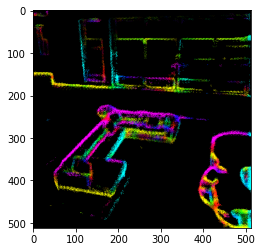

In [34]:
vis_utils.imshow(data_utils.FlowToRgb(max_speed=0.1)(c_preds_rgb) * (b_preds > 0.1).float())

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


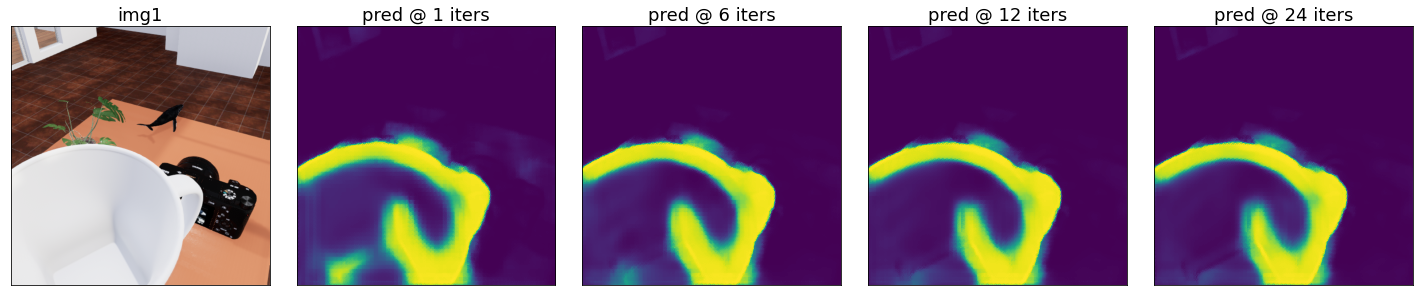

In [65]:
ex = 21
thresh = None
viz_raft_prediction(mclass_net, tdw_dataset, ex=ex, iters=[1,6,12,24], thingness=True, thresh=thresh, 
                    is_test=True, sigmoid=True)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


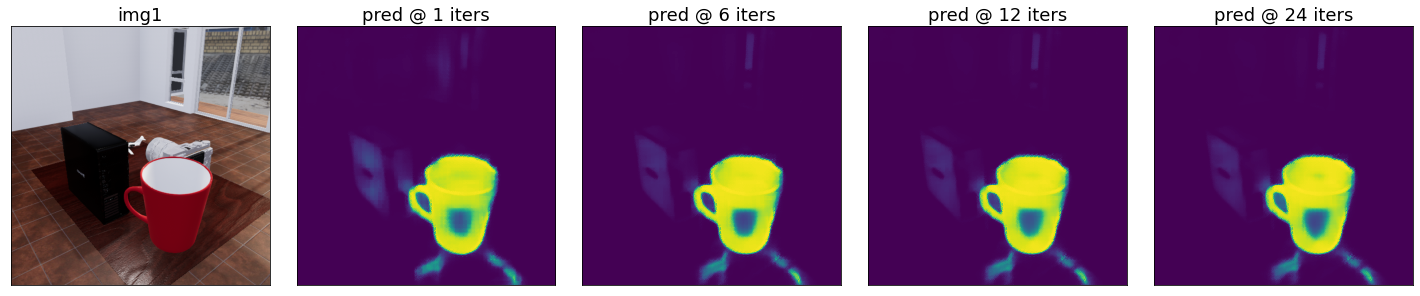

In [66]:
ex = 11
viz_raft_prediction(mclass_net, tdw_dataset, ex=ex, iters=[1,6,12,24], thingness=True, thresh=thresh, is_test=True)


In [67]:
tdw_dataset = raft_datasets.TdwFlowDataset(
#     root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
#     root='/mnt/fs5/dbear/tdw_datasets/primitives_large_v1/',
    root='/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/',
#     dataset_names=['model_split_4'],    
    dataset_names=['model_split_%d' % split for split in range(4)],
    split='validation',
#     filepattern="*[0-8]",
#     test_filepattern="0*[0-4]",
    test_filepattern="*9",
    min_start_frame=6,
    max_start_frame=6,
    scale_to_pixels=True,
    get_gt_flow=True,
    get_backward_frame=False
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)

500
True


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars


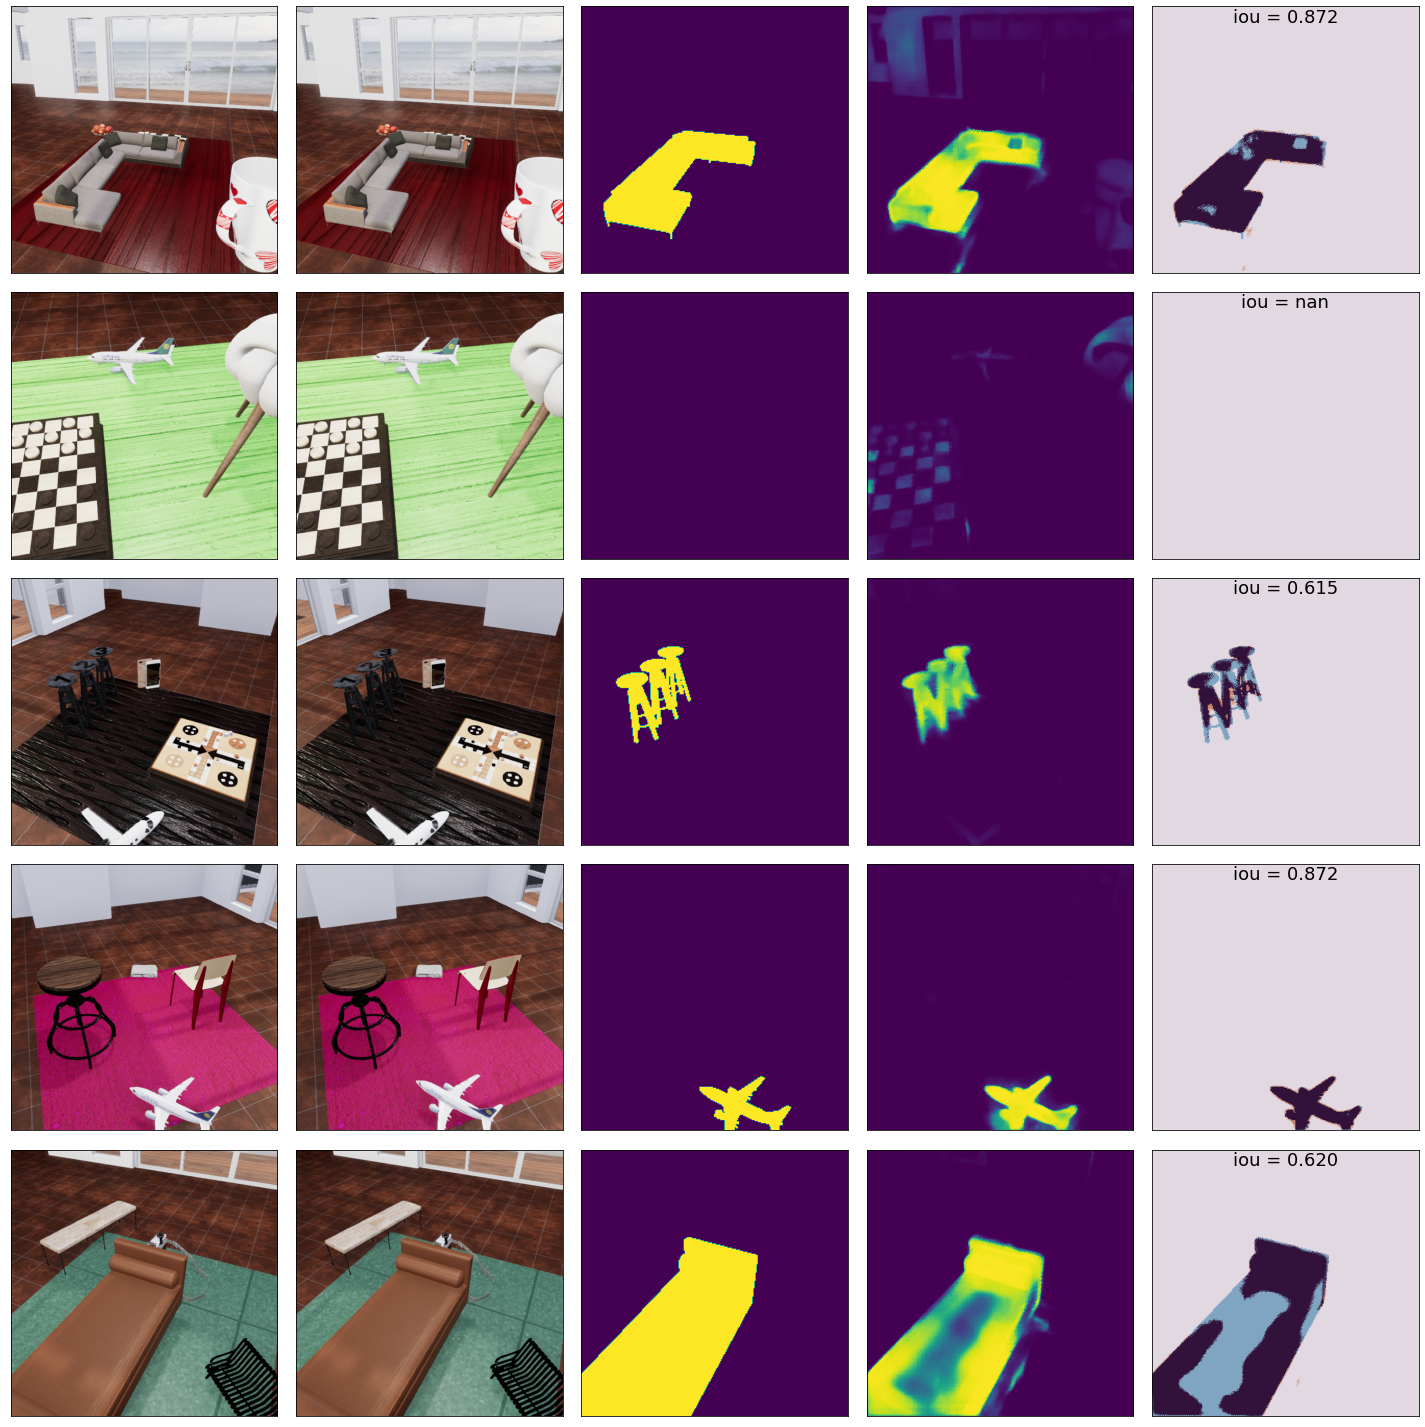

In [79]:
tdw_dataset.is_test = True
tdw_dataset.get_backward_frame = False
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
examples = range(5)
thresh = 0.75
visualize_error_maps(mclass_net, tdw_dataset, examples=examples, thresh=thresh, thingness=True, iters=12)


In [80]:
tdw_dataset.test_mode = False
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
examples = None
thresh = 0.5

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (motion_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
metrics = validate_examples(mclass_net, tdw_dataset, examples=examples, thresh=thresh, iters=12, 
                            thingness=True)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/25000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall.pth --- val = False, 500 at thresh = 0.50


  0%|          | 1/500 [00:00<02:08,  3.89it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [01:58<00:00,  4.23it/s]


({'iou': 0.770623299491513,
  'precision': 0.8369227573540989,
  'recall': 0.9142584435737409},
 {'iou_isnan': 0.04, 'precision_isnan': 0.044, 'recall_isnan': 0.048})

In [75]:
tdw_dataset.test_mode = False
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
examples = None
thresh = 0.75

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (motion_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
metrics = validate_examples(mclass_net, tdw_dataset, examples=examples, thresh=thresh, iters=12, 
                            thingness=True)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/25000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall.pth --- val = False, 500 at thresh = 0.75


  0%|          | 1/500 [00:00<01:59,  4.17it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [10:14<00:00,  1.23s/it]


({'iou': 0.7509440092406169,
  'precision': 0.884429929608529,
  'recall': 0.835051425102267},
 {'iou_isnan': 0.042, 'precision_isnan': 0.048, 'recall_isnan': 0.048})

In [244]:
tdw_dataset.test_mode = False
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
examples = None
thresh = 0.9

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (motion_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
metrics = validate_examples(mclass_net, tdw_dataset, examples=examples, thresh=thresh, iters=12, 
                            thingness=True)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/50000_motion-rnd0-tdw-bs4-large-dtarg-cthr05-pr1-tds2-fullplayall.pth --- val = False, 500 at thresh = 0.90


  0%|          | 1/500 [00:00<02:20,  3.56it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [11:36<00:00,  1.39s/it]


({'iou': 0.7144751960182528,
  'precision': 0.8977856989141246,
  'recall': 0.7792715680219506},
 {'iou_isnan': 0.04, 'precision_isnan': 0.048, 'recall_isnan': 0.048})

In [287]:
tdw_dataset.test_mode = False
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
examples = None
thresh = 0.75

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (motion_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
metrics = validate_examples(mclass_net, tdw_dataset, examples=examples, thresh=thresh, iters=12, 
                            thingness=True)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/50000_motion-rnd0-tdw-bs4-large-dtarg-cthr05-pr1-tds2-fullplayall.pth --- val = False, 500 at thresh = 0.75


  0%|          | 1/500 [00:00<03:24,  2.44it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [10:37<00:00,  1.27s/it]


({'iou': 0.7033598155344872,
  'precision': 0.771392744585118,
  'recall': 0.8861445799592351},
 {'iou_isnan': 0.01, 'precision_isnan': 0.01, 'recall_isnan': 0.048})

In [101]:
tdw_dataset.test_mode = False
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
examples = None
thresh = 0.75

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (motion_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
metrics = validate_examples(mclass_net, tdw_dataset, examples=examples, thresh=thresh, iters=12, 
                            thingness=True)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/20000_motion-rnd0-tdw-bs4-large-dtarg-cthr05-pr1-tds2-fullplayall.pth --- val = False, 500 at thresh = 0.75


  0%|          | 1/500 [00:00<02:13,  3.74it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [14:27<00:00,  1.74s/it]


({'iou': 0.723911811314682,
  'precision': 0.7946131248300766,
  'recall': 0.8868522428538926},
 {'iou_isnan': 0.018, 'precision_isnan': 0.022, 'recall_isnan': 0.048})

In [38]:
tdw_dataset.test_mode = False
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
examples = None
thresh = 0.5

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (motion_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
metrics = validate_examples(mclass_net, tdw_dataset, examples=examples, thresh=thresh, iters=12, 
                            thingness=True)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/25000_motion-rnd0-tdw-bs4-large-dtarg-cthr075-pr1-tds2-fullplayall.pth --- val = False, 500 at thresh = 0.50


  0%|          | 1/500 [00:00<04:19,  1.92it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:16<00:00,  3.65it/s]


({'iou': 0.6454190072825037,
  'precision': 0.7095631676350272,
  'recall': 0.8959315145753318},
 {'iou_isnan': 0.01, 'precision_isnan': 0.01, 'recall_isnan': 0.048})

In [36]:
tdw_dataset.test_mode = False
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
examples = None
thresh = 0.75

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (motion_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
metrics = validate_examples(mclass_net, tdw_dataset, examples=examples, thresh=thresh, iters=12, 
                            thingness=True)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 1/500 [00:00<01:30,  5.50it/s]

evaluating model --- ../checkpoints/25000_motion-rnd0-tdw-bs4-large-dtarg-cthr075-pr1-tds2-fullplayall.pth --- val = False, 500 at thresh = 0.75


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [07:02<00:00,  1.18it/s]


({'iou': 0.6785935615390444,
  'precision': 0.8249202040889687,
  'recall': 0.7974699413167682},
 {'iou_isnan': 0.02, 'precision_isnan': 0.022, 'recall_isnan': 0.048})

In [33]:
tdw_dataset.test_mode = False
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
examples = None
thresh = 0.75

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (motion_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
metrics = validate_examples(mclass_net, tdw_dataset, examples=examples, thresh=thresh, iters=24, 
                            thingness=True)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/40000_motion-rnd0-tdw-bs4-small-dtarg-cthr05-pr1-tds2.pth --- val = False, 500 at thresh = 0.75


 80%|███████▉  | 398/500 [03:52<01:01,  1.65it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [04:51<00:00,  1.71it/s]


({'iou': 0.6256696857539169,
  'precision': 0.7199148129763906,
  'recall': 0.8276132130949739},
 {'iou_isnan': 0.002, 'precision_isnan': 0.002, 'recall_isnan': 0.048})

In [77]:
tdw_dataset.test_mode = False
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
examples = None
thresh = 0.75

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (motion_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
metrics = validate_examples(mclass_net, tdw_dataset, examples=examples, thresh=thresh, iters=24, 
                            thingness=True)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/10000_motion-rnd0-tdw-bs4-small-dtarg-cthr05-pr1-tds2.pth --- val = False, 500 at thresh = 0.75


 22%|██▏       | 109/500 [00:34<01:47,  3.62it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:34<00:00,  3.24it/s]


({'iou': 0.6933885210319576,
  'precision': 0.8053836499521168,
  'recall': 0.836005549814805},
 {'iou_isnan': 0.016, 'precision_isnan': 0.016, 'recall_isnan': 0.048})

In [69]:
tdw_dataset.test_mode = False
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
examples = None
thresh = 0.9

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (motion_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
metrics = validate_examples(mclass_net, tdw_dataset, examples=examples, thresh=thresh, iters=24, 
                            thingness=True)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/45000_motion-rnd0-tdw-bs1-small-dtarg-cthr05-pr1.pth --- val = False, 500 at thresh = 0.90


 26%|██▌       | 130/500 [01:16<04:01,  1.53it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [05:09<00:00,  1.62it/s]


({'iou': 0.6206567150807454,
  'precision': 0.7403924020702168,
  'recall': 0.7893531531623622},
 {'iou_isnan': 0.004, 'precision_isnan': 0.006, 'recall_isnan': 0.048})

In [84]:
tdw_dataset.test_mode = False
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
examples = None
thresh = 0.75

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (motion_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
metrics = validate_examples(mclass_net, tdw_dataset, examples=examples, thresh=thresh, iters=24, thingness=True)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/10000_motion-rnd0-tdw-bs1-small-imtarg-thr0-pr1-tds2.pth --- val = False, 500 at thresh = 0.75


 22%|██▏       | 109/500 [00:34<01:39,  3.93it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:36<00:00,  3.20it/s]


({'iou': 0.6846314479641402,
  'precision': 0.7510709214500889,
  'recall': 0.879307360684904},
 {'iou_isnan': 0.014, 'precision_isnan': 0.014, 'recall_isnan': 0.048})

In [86]:
tdw_dataset.test_mode = False
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
examples = None
thresh = 0.9

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (motion_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
metrics = validate_examples(mclass_net, tdw_dataset, examples=examples, thresh=thresh, iters=24, thingness=True)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/10000_motion-rnd0-tdw-bs1-small-imtarg-thr0-pr1-tds2.pth --- val = False, 500 at thresh = 0.90


  0%|          | 1/500 [00:00<03:56,  2.11it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:34<00:00,  3.24it/s]


({'iou': 0.6841182206440041,
  'precision': 0.8611612909615204,
  'recall': 0.7636474794258898},
 {'iou_isnan': 0.032, 'precision_isnan': 0.034, 'recall_isnan': 0.048})

# Implement parts of diffusionRNN one at a time

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


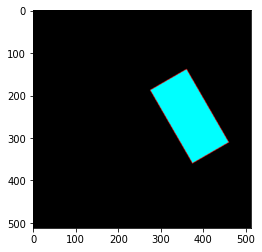

In [13]:
def rectangle(imsize=[512,512], height=200, width=100, offset=[0,0], rotation=0):
    im = torch.zeros([1,1,*imsize]).float()
    h, w = height // 2, width // 2
    ch, cw = [offset[0] + imsize[0]//2, offset[1] + imsize[1]//2]
    hmin, hmax = max(ch-h, 0), min(ch+h, imsize[0])
    wmin, wmax = max(cw-w, 0), min(cw+w, imsize[1])
    im[:,:,hmin:hmax,wmin:wmax] = 1.0
    if rotation != 0:
        im = transforms.RandomRotation((rotation,rotation))(im)
    return im

# vis_utils.imshow(rectangle(offset=[50,100], rotation=30))
rect = rectangle(offset=[50,100], rotation=30)
# rect = rectangle(imsize=[128,128], offset=[12,25], rotation=30)

rect_inner = rectangle(height=180, width=80, offset=[50,100], rotation=30)
# rect = rect - rect_inner
rect_boundaries, _ = fprop.get_mask_boundaries(rect)
rect_vis = torch.cat([rect_boundaries, rect*(1-rect_boundaries), rect*(1-rect_boundaries)], 1)
vis_utils.imshow(rect_vis)
# vis_utils.imshow(rect_vis[:,:,180:220,280:320])

In [14]:
ors = fprop.estimate_boundary_orientations(rect_boundaries, rect, to_circle=False)
ors = ors * rect_boundaries

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


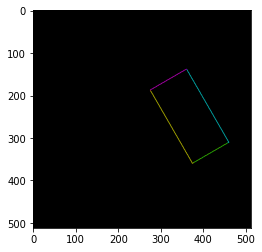

In [15]:
ors_rgb = data_utils.FlowToRgb(max_speed=0.2)(ors)
vis_utils.imshow(ors_rgb)
# vis_utils.imshow(ors_rgb[:,:,180:220,280:320])

In [16]:
ors = fprop.estimate_boundary_orientations(rect_boundaries, rect, to_circle=True, beta=10.0)
ors = ors * rect_boundaries

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
# vis_utils.imshow(ors[:,[1,2,5],None,180:220,280:320].sum(1), cmap='magma', vmin=0, vmax=1)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
from time import time
b_flux = fprop.get_oriented_flux(rect_boundaries.cuda(), ors.cuda(), rect.cuda())
b_flux = b_flux * (1 - rect_boundaries.cuda())

effects = fprop.compute_local_effects(
    (rect * rect_boundaries).cuda(), ors.cuda()
)
num_px = fprop.compute_local_effects(
    (rect * rect_boundaries).cuda(), torch.ones_like(ors.cuda())
)
effects = effects / num_px.clamp(min=1)
effects_mask = (num_px > 0).float()

num_px_int = fprop.compute_local_effects(
            (1 - rect_boundaries.cuda()), torch.ones_like(ors.cuda())
        ).clamp(min=1)

diff = effects * (1 - rect_boundaries.cuda())

h0 = rect_boundaries.cuda()
h = h0.clone()


t0 = time()
eta = 1.0
for it in range(1000):
#     h = h + eta * (b_flux - h) * effects_mask * (1 - h0) + h0
    h = h + eta * (b_flux - h) * (1 - h0) * effects_mask

#     flux = fprop.compute_local_effects(
#         h * (1 - rect_boundaries.cuda()), torch.ones_like(ors.cuda())
#     )
#     flux = flux / num_px_int
    
#     h = 0.5*(h + flux)*(1-h0) + h0
    h_avg = fprop.local_average(h, excluded=h0)
    h = h_avg * (1-h0) + h0
    
#     h = (h > 0.25).float()
    
t1 = time()
print(t1-t0)
e_vis = torch.cat([rect_boundaries.cuda(), effects, 0.5*effects], 1)



/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.4486050605773926


In [19]:
h.amax()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor(1., device='cuda:0')

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


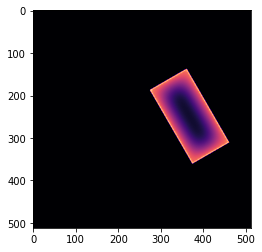

In [20]:
# vis_utils.imshow(e_vis[:,:,180:220,280:320], cmap='magma', vmin=0, vmax=1)
# vis_utils.imshow(h[:,:,180:220,280:320], cmap='magma', vmin=0, vmax=1)
vis_utils.imshow(h, cmap='magma', vmin=0, vmax=1)

# vis_utils.imshow(effects[:,:,180:220,280:320], cmap='magma', vmin=0, vmax=1)
# vis_utils.imshow(diff[:,:,180:220,280:320], cmap='magma', vmin=0, vmax=1)

In [627]:
(h * (1-h0)).amax()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor(0.9733, device='cuda:0')

In [549]:
h0.amax()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor(1., device='cuda:0')

In [457]:
flux = fprop.get_oriented_flux(rect_boundaries.cuda(), ors.cuda(), rect.cuda())

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


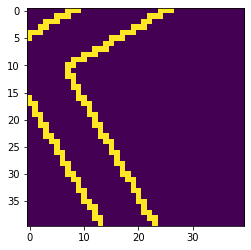

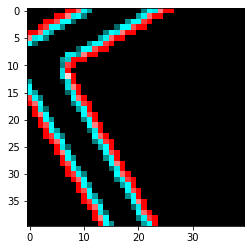

In [466]:
f_viz = torch.cat([rect_boundaries.cuda(), flux, flux], 1)
vis_utils.imshow(rect_boundaries[:,:,180:220,280:320])
vis_utils.imshow(f_viz[:,:,180:220,280:320])

In [663]:
moments = fprop.local_spatial_moments(rect.cuda(), radius=1, squeeze=True)
borderness = moments.abs().mean(1, True) * rect.cuda()
borderness.amax()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor(0.4000, device='cuda:0')

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


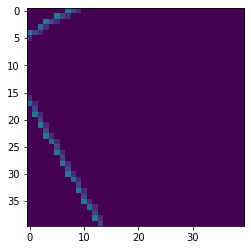

In [662]:
# vis_utils.imshow(moments.abs().mean(1, True)[:,:,180:220,280:320], vmin=0, vmax=1.0)
vis_utils.imshow(borderness[:,:,180:220,280:320], vmin=0, vmax=1.0)

In [213]:
ex = 21
tdw_dataset.get_backward_frame = True
IM.thresh = 0.01
MS = fprop.MotionEnergySampler(1, binarize=True, thresh=None, to_nodes=False).cuda()
x1, x2, x0 = [x[None].cuda() for x in tdw_dataset[ex][:3]]
_, mprior = mclass_net(x1, x2, test_mode=True, iters=24)
mtarget = IM(torch.stack([x0,x1,x2], 1) / 255.)
print(mprior.shape, mtarget.shape)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RuntimeError: CUDA out of memory. Tried to allocate 294.00 MiB (GPU 0; 11.91 GiB total capacity; 10.45 GiB already allocated; 36.38 MiB free; 11.08 GiB reserved in total by PyTorch)

In [ ]:
vis_utils.imshow(mprior)
vis_utils.imshow(F.relu(mtarget[:,0]))

In [208]:
S, P = 1, 2048
stride = 4
radius = 5
beta = 10.0
B,_,H,W = mprior.shape
_H,_W = [H // stride, W // stride]
m0 = F.avg_pool2d(mprior, stride, stride=stride).sigmoid()
b0 = fprop.sample_boundaries_from_energy(mprior, stride=stride, num_samples=S, num_points=P).view(B*S,1,_H,_W)
c0 = fprop.estimate_boundary_orientations(b0, m0, radius=radius, to_circle=True, beta=beta) * b0
c0xy = fprop.estimate_boundary_orientations(b0, m0, radius=radius, to_circle=False) * b0


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


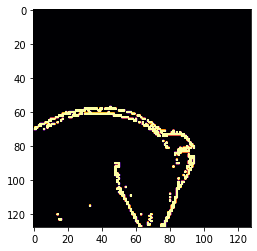

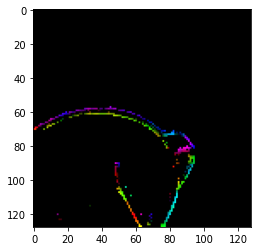

In [209]:
vis_utils.imshow(b0, cmap='inferno', vmin=0, vmax=0.2)
vis_utils.imshow(data_utils.FlowToRgb(max_speed=0.5)(c0xy))

In [210]:
from time import time
slope = None

h0 = b0 + m0 * (1 - b0)
# h0 = b0
b_flux = fprop.get_oriented_flux(b0, c0, b0)
b_flux = b_flux * (1 - b0)

# num_px = fprop.compute_local_effects(
#     b0 * m0, torch.ones_like(c0)
# )
# b_flux_mask = (num_px > 0).float()
# b_flux_mask = (b_flux > 0).float()

b_flux_mask = (fprop.compute_local_effects(
    b0, c0) > 0.5).float()


t0 = time()
eta = 1.0
h = h0.clone()

n_iters = 100

for it in range(n_iters):
#     h = h * (1 - b_flux_mask) + eta * (b_flux) * (1 - b0) * b_flux_mask    
#     h = h * (1 - b_flux_mask) + eta * (b_flux) * b_flux_mask          
    h = h * (1-b_flux_mask) + eta * b_flux * b_flux_mask
    
    if (it) != n_iters:
        h_avg = fprop.local_average(h, excluded=b0)
        h = h_avg * (1-h0) + h0
    
#     h = h + eta * (b_flux - h) * (1 - h0) * effects_mask

#     flux = fprop.compute_local_effects(
#         h * (1 - rect_boundaries.cuda()), torch.ones_like(ors.cuda())
#     )
#     flux = flux / num_px_int
    
#     h = 0.5*(h + flux)*(1-h0) + h0
#     h_avg = fprop.local_average(h, excluded=b0)
#     h = h_avg * (1-b0) + b0
    
    h = (h > 0.5).float()
    if slope is not None:
        h = torch.sigmoid((h - 0.5) * slope)
    
t1 = time()
print(t1-t0)


0.05400800704956055


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [211]:
h.amax()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor(1., device='cuda:0')

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


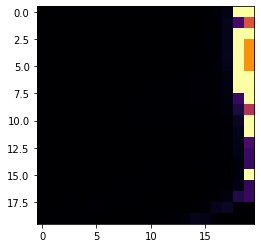

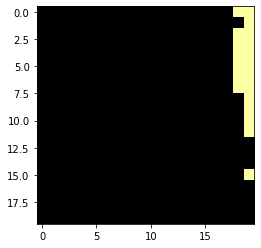

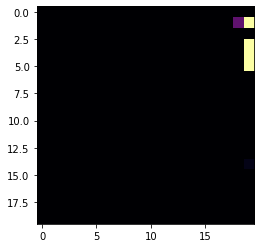

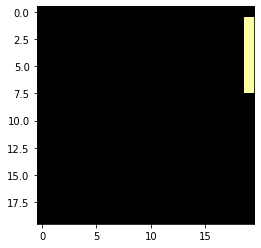

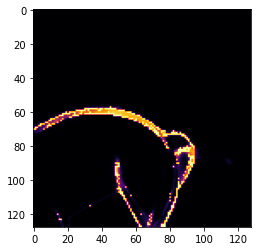

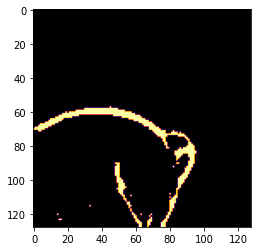

In [212]:
vis_utils.imshow(h0[:,:,90:110,30:50], cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(h[:,:,90:110,30:50], cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(b_flux[:,:,90:110,30:50], cmap='inferno', vmin=0, vmax=1.0)
# vis_utils.imshow(data_utils.FlowToRgb(max_speed=0.5)(c0xy)[:,:,90:110,30:50])
vis_utils.imshow(b_flux_mask[:,:,90:110,30:50], cmap='inferno', vmin=0, vmax=1)
# vis_utils.imshow(c0[:,1:2,90:110,30:50], cmap='inferno', vmin=0, vmax=1)

vis_utils.imshow(h0, cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(h > 0.95, cmap='inferno', vmin=0, vmax=1)
# vis_utils.imshow(h > 0.5, cmap='inferno', vmin=0, vmax=1)


In [191]:
P = 2048
m1 = h.clone()
b1 = fprop.sample_boundaries_from_energy(m1, stride=1, num_samples=S, num_points=P).view(B*S,1,_H,_W)
c1 = fprop.estimate_boundary_orientations(b1, m1, radius=radius, to_circle=True, beta=beta) * b1
c1xy = fprop.estimate_boundary_orientations(b1, m1, radius=radius, to_circle=False) * b1

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


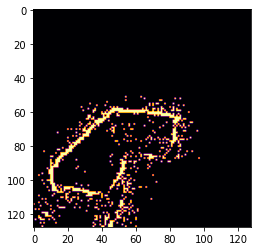

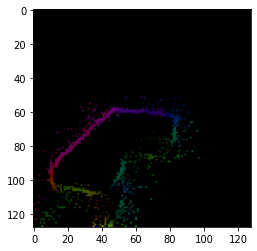

In [192]:
vis_utils.imshow(b1, cmap='inferno', vmin=0, vmax=1.0)
vis_utils.imshow(data_utils.FlowToRgb(max_speed=1.0)(c1xy))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


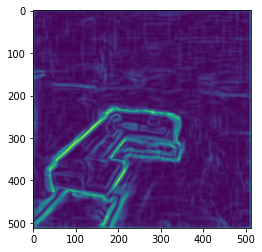

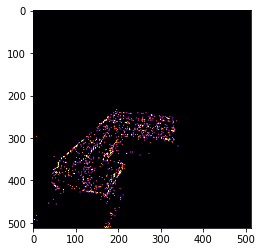

In [794]:
P = 1024
vis_utils.imshow(moments.abs().sum(1, True))
msamples = MS((moments.abs().sum(1, True) * motion)[:,None],
              num_points=P,
              eps=0)[0][:,0]
vis_utils.imshow(msamples, cmap='inferno', vmin=0, vmax=0.25)


In [798]:
orients = fprop.estimate_boundary_orientations(
    boundaries=msamples,
    energy=motion,
    to_circle=False,
    beta=10.0
)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


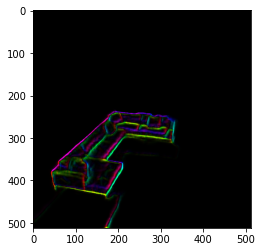

In [804]:
vis_utils.imshow(data_utils.FlowToRgb(max_speed=0.25)(orients) * motion)

In [808]:
b0 = orients.abs().sum(1, True) * motion
b0_moments = fprop.local_spatial_moments(b0, radius=5, squeeze=True)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


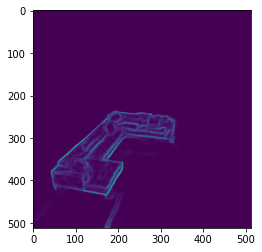

In [816]:
vis_utils.imshow(b0)

In [905]:
orients = fprop.estimate_boundary_orientations(
    boundaries=(msamples * motion),
    energy=motion,
    radius=3,
    to_circle=True,
    beta=10.0
)
b1 = (1 - orients[:,4:5]) * motion
tangents = fprop.get_local_neighbors(
    (msamples * motion), radius=1, to_image=True, invalid=0)[:,0]
tangents = tangents / tangents.sum(1, True).clamp(min=1)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


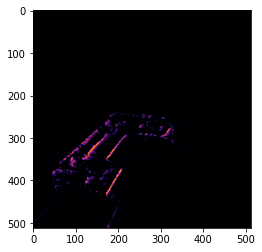

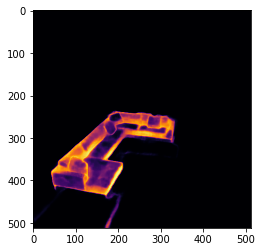

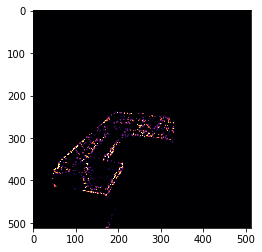

In [906]:
# vis_utils.imshow(data_utils.FlowToRgb(max_speed=0.25)(orients) * motion)
vis_utils.imshow(orients[:,0:1] * motion, cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow((1-orients[:,4:5]) * motion, cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(tangents[:,0:1] * motion, cmap='inferno', vmin=0, vmax=0.1)


In [888]:
orients = fprop.estimate_boundary_orientations(
    boundaries=rect_boundaries.cuda(),
    energy=rect.cuda(),
    radius=3,
    to_circle=True,
    beta=10.0
)

# b1 = 1 - (orients[:,4:5] * rect.cuda())
# tangents = fprop.estimate_boundary_orientations(
#     boundaries=torch.zeros_like(rect).cuda(),
#     energy=rect_boundaries.cuda(),
#     radius=3,
#     to_circle=True,
#     beta=10.0
# )
tangents = fprop.get_local_neighbors(rect_boundaries.cuda(), radius=1, to_image=True, invalid=0)[:,0]
tangents.shape

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([1, 9, 512, 512])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


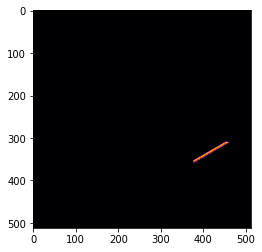

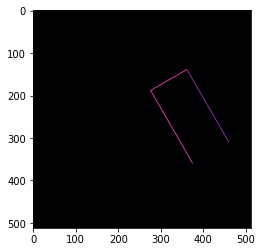

In [890]:
vis_utils.imshow(orients[:,0:1] * rect.cuda(), cmap='inferno', vmin=0, vmax=1)
# vis_utils.imshow(rect.cuda() * (1 - orients[:,4:5]), cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(tangents[:,0:1] * rect.cuda(), cmap='inferno', vmin=0, vmax=1)

In [869]:
b1.amin()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor(0., device='cuda:0')